
#**Stock Market Indexes Predictions**

#Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
# !pip install pystan~=2.14
# !pip install fbprophet
# warnings.filterwarnings('ignore')
# import fbprophet
# # print version number
# print('Prophet %s' % fbprophet.__version__)
# from matplotlib import pyplot
# from fbprophet import Prophet
from prophet import Prophet
import holidays


#NIfty 50

In [3]:
#Reading Nifty File
df_Nifty = pd.read_csv('/content/NIFTY50.csv')
df_Nifty["date_clean"] = df_Nifty["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_Nifty['year']=df_Nifty['date_clean'].apply(lambda x: x.year)
df_Nifty['Month']=df_Nifty['date_clean'].apply(lambda x: x.month)
df_Nifty['day']=df_Nifty['date_clean'].apply(lambda x: x.day)
#df_Nifty=df_Nifty[(df_Nifty['year']>=2020)]
df_Nifty=df_Nifty[((df_Nifty['year']==2021)&(df_Nifty['Month']>6))|((df_Nifty['year']==2022)&(df_Nifty['Month']>=1))]
df_Nifty.head()

,Date,Open,High,Low,Close,Adj Close,Volume,date_clean,year,Month,day
615,01-07-2021,15755.05,15755.55,15667.05,15680.00,15680.00,224900.0,2021-07-01,2021,7,1
616,02-07-2021,15705.85,15738.35,15635.95,15722.20,15722.20,254800.0,2021-07-02,2021,7,2
617,05-07-2021,15793.40,15845.95,15762.05,15834.35,15834.35,207000.0,2021-07-05,2021,7,5
618,06-07-2021,15813.75,15914.20,15801.00,15818.25,15818.25,391400.0,2021-07-06,2021,7,6
619,07-07-2021,15819.60,15893.55,15779.70,15879.65,15879.65,329300.0,2021-07-07,2021,7,7


##EDA

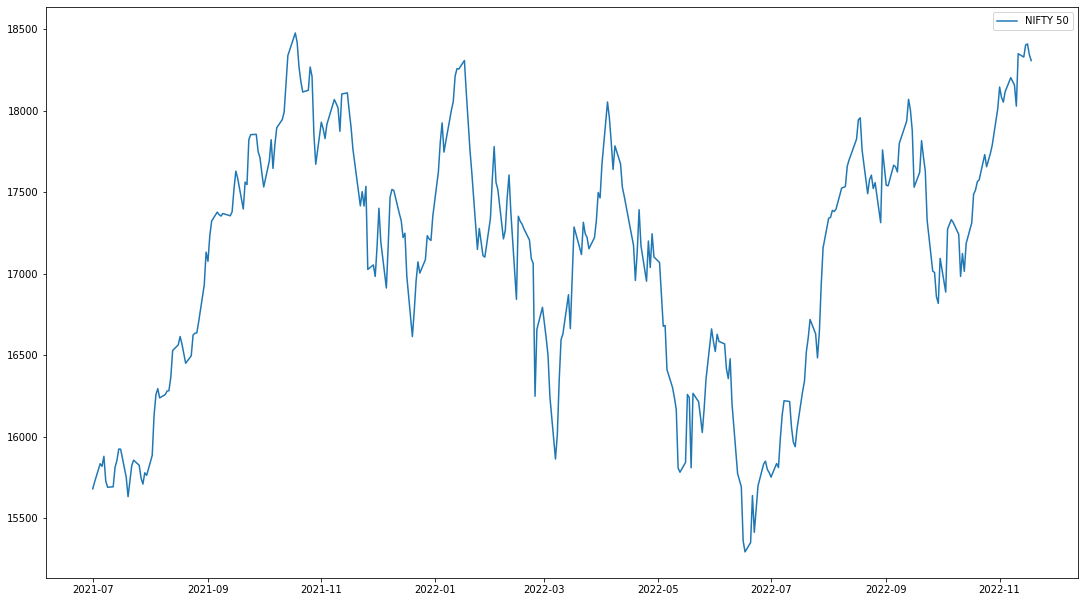

In [4]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(df_Nifty['date_clean'],df_Nifty["Close"], label='NIFTY 50')
pyplot.legend()
pyplot.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/oqu6pxdp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/63iuu4fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68243', 'data', 'file=/tmp/tmp9puoo3fo/oqu6pxdp.json', 'init=/tmp/tmp9puoo3fo/63iuu4fg.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_model5569flot/prophet_model-20221120084114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:

MAE: 154.919
MAPE: 0.844
MAE_NIFTY =  154.9191413635781
MAPE_NIFTY =  0.8435915570031087
RMSE_NIFTY =  159.44883057162227
          ds          yhat    yhat_lower    yhat_upper
0 2022-11-14  18134.812063  17145.458434  19123.951618
1 2022-11-15  18211.405431  17220.517807  19144.644414
2 2022-11-16  18242.877604  17253.911956  19260.550515
3 2022-11-17  18224.541259  17247.353604  19270.680865
4 2022-11-18  18205.517936  17246.535544  19141.294370
           ds         y
0  2022-11-14  18329.15
1  2022-11-15  18403.40
2  2022-11-16  18409.65
3  2022-11-17  18343.90
4  2022-11-18  18307.65


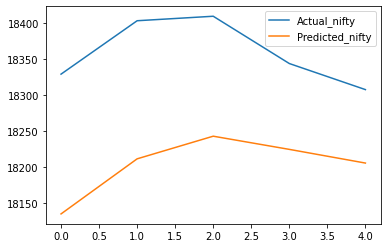

In [5]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nifty=preprocessing(df_Nifty)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    
def ProhetModel(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 3,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=20,
                      daily_seasonality = False,
                      #yearly_seasonality = 5,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=4, mode='additive')
  #final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5,mode='additive')
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_nifty, mape_nifty, forecast_nifty,test_val_nifty,rmse_nifty,train_val_nifty = ProhetModel(DF_Nifty,'India')
print('MAE_NIFTY = ',mae_nifty)
print('MAPE_NIFTY = ', mape_nifty)
print('RMSE_NIFTY = ',rmse_nifty)
print(forecast_nifty[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_nifty)

from matplotlib import pyplot
pyplot.plot(test_val_nifty["y"], label='Actual_nifty')
pyplot.plot(list(forecast_nifty["yhat"]), label='Predicted_nifty')
pyplot.legend()
pyplot.show()



##Predicting for 21st Oct to 25th Nov

In [7]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_Nifty["ds"][DF_Nifty.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_nifty = pd.DataFrame({"ds":future})
test_nifty = test_nifty.reset_index(drop=True)
print(test_nifty)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-24
4  2022-11-25


In [9]:
def ProhetModel_test_nifty(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 3,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=20,
                      daily_seasonality = False,
                      #yearly_seasonality = 5,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=4, mode='additive')
  #final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5,mode='additive')
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  #final_model.add_seasonality(name='quarterly', period=30.5)
  #final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  #final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val)
  a=final_model.train_holiday_names.to_list()
  return forecast , test_val,train_val

train_nifty=DF_Nifty.copy()
final_forecast_nifty,final_test_val_nifty,final_train_val_nifty = ProhetModel_test_nifty(test_nifty,train_nifty,'India')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/lekeljow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/o7zi8ku0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88134', 'data', 'file=/tmp/tmp9puoo3fo/lekeljow.json', 'init=/tmp/tmp9puoo3fo/o7zi8ku0.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_model9554vduz/prophet_model-20221120084434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:

In [10]:
print(final_forecast_nifty[['ds','yhat','yhat_lower','yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-21  18191.853596  17170.184661  19151.668015
1 2022-11-22  18250.285513  17199.956741  19206.419463
2 2022-11-23  18264.826682  17244.638919  19208.587277
3 2022-11-24  18235.778069  17209.433824  19283.504116
4 2022-11-25  18203.535161  17257.597262  19199.673618


#FTSE 100

In [11]:
#Reading FTSE File
df_FTSE = pd.read_csv('/content/FTSE 100.csv')
df_FTSE["date_clean"] = df_FTSE["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_FTSE['year']=df_FTSE['date_clean'].apply(lambda x: x.year)
df_FTSE['Month']=df_FTSE['date_clean'].apply(lambda x: x.month)
df_FTSE['day']=df_FTSE['date_clean'].apply(lambda x: x.day)
#df_FTSE=df_FTSE[df_FTSE['year'].isin([2021,2022])]
df_FTSE=df_FTSE[((df_FTSE['year']==2021)&(df_FTSE['Month']>=1))|((df_FTSE['year']==2022)&(df_FTSE['Month']>=1))]
df_FTSE.head()

,Date,Close,Open,High,Low,Volume,Chg%,date_clean,year,Month,day
0,18-11-2022,7385.52,NaN,NaN,NaN,NaN,NaN,2022-11-18,2022,11,18
1,17-11-2022,7346.54,NaN,NaN,NaN,NaN,NaN,2022-11-17,2022,11,17
2,16-11-2022,7351.19,NaN,NaN,NaN,NaN,NaN,2022-11-16,2022,11,16
3,15-11-2022,7369.44,NaN,NaN,NaN,NaN,NaN,2022-11-15,2022,11,15
4,14-11-2022,7385.17,NaN,NaN,NaN,NaN,NaN,2022-11-14,2022,11,14


#EDA

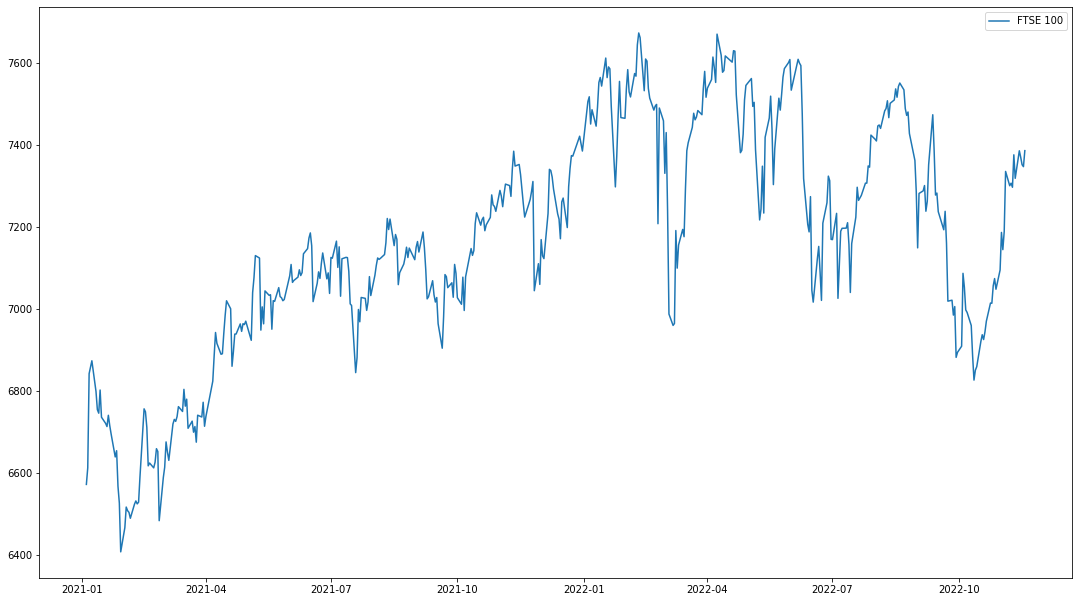

In [12]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(df_FTSE['date_clean'],df_FTSE["Close"], label='FTSE 100')
pyplot.legend()
pyplot.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/12ny1lwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/ldujzysx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73366', 'data', 'file=/tmp/tmp9puoo3fo/12ny1lwp.json', 'init=/tmp/tmp9puoo3fo/ldujzysx.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelh8silsaz/prophet_model-20221120084957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 25.050
MAPE: 0.340
MAE_ftse =  25.050417109569025
MAPE_ftse =  0.33975673492170333
RMSE_ftse =  27.843986951419595
          ds         yhat   yhat_lower   yhat_upper
0 2022-11-14  7345.445940  7157.160964  7523.879369
1 2022-11-15  7359.222715  7176.909518  7551.961918
2 2022-11-16  7377.502255  7197.815698  7551.457001
3 2022-11-17  7358.765620  7169.467146  7537.852907
4 2022-11-18  7348.747134  7160.243968  7533.696551
           ds        y
0  2022-11-14  7385.17
1  2022-11-15  7369.44
2  2022-11-16  7351.19
3  2022-11-17  7346.54
4  2022-11-18  7385.52


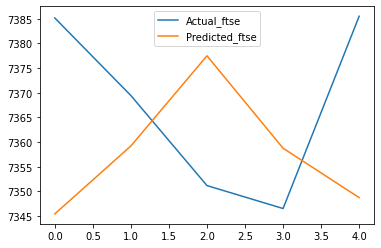

In [13]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_FTSE=preprocessing(df_FTSE)    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def ProhetModel(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=40,
                      daily_seasonality = False,
                      yearly_seasonality = 10,
                      #quarterly_seasonality = True,
                      interval_width=0.95)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_ftse, mape_ftse, forecast_ftse,test_val_FTSE,rmse_ftse,train_val_ftse = ProhetModel(DF_FTSE,'UK')
print('MAE_ftse = ',mae_ftse)
print('MAPE_ftse = ', mape_ftse)
print('RMSE_ftse = ',rmse_ftse)
print(forecast_ftse[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_FTSE)

from matplotlib import pyplot
pyplot.plot(test_val_FTSE["y"], label='Actual_ftse')
pyplot.plot(list(forecast_ftse["yhat"]), label='Predicted_ftse')
pyplot.legend()
pyplot.show()


##Predicting(FTSE) for final data 7th Nov to 11th Nov

In [14]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_FTSE["ds"][DF_FTSE.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_ftse = pd.DataFrame({"ds":future})
test_ftse = test_ftse.reset_index(drop=True)
print(test_ftse)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-24
4  2022-11-25


In [15]:
def ProhetModel_test_ftse(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=40,
                      daily_seasonality = False,
                      yearly_seasonality = 10,
                      #quarterly_seasonality = True,
                      interval_width=0.95)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_country_holidays(country_name=CountryName)
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  forecast = final_model.predict(test_val)
  return forecast , test_val,train_val

In [16]:
train_ftse=DF_FTSE.copy()
final_forecast_ftse,final_test_val_ftse,final_train_val_ftse = ProhetModel_test_ftse(test_ftse,train_ftse,'UK')


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/t4if0i9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/iz63xadn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93023', 'data', 'file=/tmp/tmp9puoo3fo/t4if0i9p.json', 'init=/tmp/tmp9puoo3fo/iz63xadn.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_model3op3mz4_/prophet_model-20221120085130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:51:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
print(final_forecast_ftse[['ds','yhat','yhat_lower','yhat_upper']])

          ds         yhat   yhat_lower   yhat_upper
0 2022-11-21  7332.379774  7149.013306  7525.361527
1 2022-11-22  7338.851145  7148.570119  7530.912385
2 2022-11-23  7345.383246  7159.257147  7526.144687
3 2022-11-24  7317.045418  7140.989335  7502.436719
4 2022-11-25  7304.885816  7117.929967  7486.284318


#Nasdaq 100

In [19]:
#Reading NASDAQ File
df_Nasdaq = pd.read_csv('/content/Nasdaq100.csv')
df_Nasdaq["date_clean"] = df_Nasdaq["Date"].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y').date() )
df_Nasdaq['year']=df_Nasdaq['date_clean'].apply(lambda x: x.year)
df_Nasdaq['Month']=df_Nasdaq['date_clean'].apply(lambda x: x.month)
df_Nasdaq['day']=df_Nasdaq['date_clean'].apply(lambda x: x.day)
df_Nasdaq=df_Nasdaq[df_Nasdaq['year'].isin([2022])]
#df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>9))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=1))]
#df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>12))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=7)|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']==6)&(df_Nasdaq['day']>=20)))]
df_Nasdaq=df_Nasdaq[((df_Nasdaq['year']==2021)&(df_Nasdaq['Month']>12))|((df_Nasdaq['year']==2022)&(df_Nasdaq['Month']>=6))]
df_Nasdaq
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nasdaq=preprocessing(df_Nasdaq)
DF_Nasdaq

,ds,y
0,2022-06-01,12548.36
1,2022-06-02,12892.89
2,2022-06-03,12548.02
3,2022-06-06,12599.63
4,2022-06-07,12711.67
...,...,...
115,2022-11-14,11700.94
116,2022-11-15,11871.15
117,2022-11-16,11699.09
118,2022-11-17,11676.86


##EDA

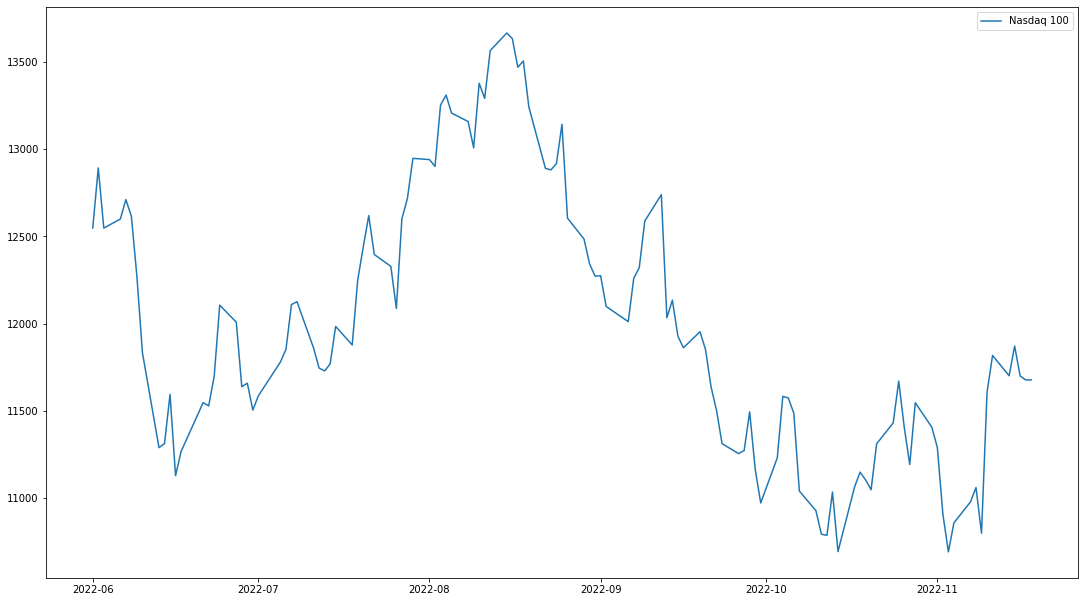

In [20]:
from matplotlib import pyplot
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
pyplot.plot(DF_Nasdaq['ds'],DF_Nasdaq["y"], label='Nasdaq 100')
pyplot.legend()
pyplot.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/6di3r87k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/4y5elsl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18519', 'data', 'file=/tmp/tmp9puoo3fo/6di3r87k.json', 'init=/tmp/tmp9puoo3fo/4y5elsl9.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelfvtetmlj/prophet_model-20221120090934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:09:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:09:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 151.451
MAPE: 1.295
MAE_Nasdaq =  151.4511994960456
MAPE_Nasdaq =  1.2950945648188716
RMSE_Nasdaq =  200.988843906211
          ds          yhat    yhat_lower    yhat_upper
0 2022-11-14  12057.846385  11675.311673  12479.071858
1 2022-11-15  11853.156695  11441.697191  12285.657743
2 2022-11-16  11747.294760  11302.157672  12141.915606
3 2022-11-17  11599.573765  11182.301761  12031.914322
4 2022-11-18  11420.154687  11017.200767  11835.203996
           ds         y
0  2022-11-14  11700.94
1  2022-11-15  11871.15
2  2022-11-16  11699.09
3  2022-11-17  11676.86
4  2022-11-18  11677.02


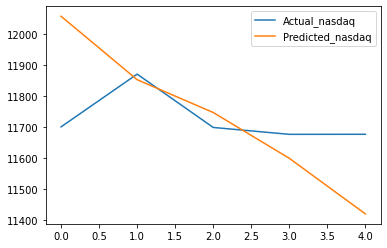

In [21]:
def preprocessing(df):
  df=df.sort_values(by=["date_clean"],ascending=True)
  df=df.rename(columns={'date_clean':'ds','Close':'y'})
  df=df.reset_index(drop=True)
  df=df[['ds','y']]
  return df

DF_Nasdaq=preprocessing(df_Nasdaq)

    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def ProhetModel_nasdaq(DF,CountryName):
  #train test split
  df2_test=DF[-5:]
  df2_train=DF[:-5]
  test_val = df2_test.copy()
  train_val = df2_train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.3,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=10,
                      daily_seasonality = 10,
                      yearly_seasonality = False,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_regressor('regressor', mode='additive')
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  #FutureDates_nasdaq=final_model.make_future_dataframe(periods=1)
  forecast = final_model.predict(test_val.drop("y", axis=1))
  mae = mean_absolute_error(test_val["y"], list(forecast["yhat"]))
  print('MAE: %.3f' % mae)
  mape = mean_absolute_percentage_error(test_val["y"], list(forecast["yhat"]))
  print('MAPE: %.3f' % mape)
  se = np.square(test_val["y"] -list(forecast["yhat"]))
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return mae, mape, forecast , test_val,rmse,train_val

mae_nasdaq, mape_nasdaq, forecast_nasdaq,test_val_nasdaq,rmse_nasdaq,train_val_nasdaq = ProhetModel_nasdaq(DF_Nasdaq,'US')
print('MAE_Nasdaq = ',mae_nasdaq)
print('MAPE_Nasdaq = ', mape_nasdaq)
print('RMSE_Nasdaq = ',rmse_nasdaq)
print(forecast_nasdaq[['ds','yhat','yhat_lower','yhat_upper']])
print(test_val_nasdaq)

from matplotlib import pyplot
pyplot.plot(test_val_nasdaq["y"], label='Actual_nasdaq')
pyplot.plot(list(forecast_nasdaq["yhat"]), label='Predicted_nasdaq')
pyplot.legend()
pyplot.show()


##Predicting(NASDAQ) for final data 21th Nov to 25th Nov

In [37]:
import dateutil
future = []
for i in range(3,8,1):
  future.append(DF_Nasdaq["ds"][DF_Nasdaq.shape[0]-1] + dateutil.relativedelta.relativedelta(days=i))
  
test_nasdaq = pd.DataFrame({"ds":future})
test_nasdaq.drop(test_nasdaq.index[3], inplace=True)
test_nasdaq = test_nasdaq.reset_index(drop=True)
print(test_nasdaq)

           ds
0  2022-11-21
1  2022-11-22
2  2022-11-23
3  2022-11-25


In [38]:
def ProhetModel_test_nasdaq(test,train,CountryName):
  #train test split
  test_val = test.copy()
  train_val = train.copy()
  train_val = train_val.reset_index(drop=True)
  test_val = test_val.reset_index(drop=True)

  # Setup model with holidays
  final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.3,
                      #holidays_prior_scale = 0.3,
                      n_changepoints = 2,
                      seasonality_mode = 'additive',
                      weekly_seasonality=10,
                      daily_seasonality = 10,
                      yearly_seasonality = False,
                      interval_width=0.95)
  final_model.add_country_holidays(country_name=CountryName)
  final_model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
  final_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  #final_model.add_regressor('regressor', mode='additive')
  #final_model.add_seasonality(name='quarterly', period=30.5,fourier_order=5)
  final_model.fit(train_val)
  #FutureDates_nasdaq=final_model.make_future_dataframe(periods=1)
  #forecast = final_model.predict(test_val.drop("y", axis=1))
  forecast = final_model.predict(test_val)
  return forecast , test_val,train_val
train_nasdaq=DF_Nasdaq.copy()
final_forecast_nasdaq,final_test_val_nasdaq,final_train_val_nasdaq = ProhetModel_test_nasdaq(test_nasdaq,train_nasdaq,'UK')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/lmlyz07m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puoo3fo/tl1fhhx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60228', 'data', 'file=/tmp/tmp9puoo3fo/lmlyz07m.json', 'init=/tmp/tmp9puoo3fo/tl1fhhx4.json', 'output', 'file=/tmp/tmp9puoo3fo/prophet_modelzto76i_c/prophet_model-20221120091403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
print(final_forecast_nasdaq[['ds','yhat','yhat_lower','yhat_upper']])

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-21  11072.483400  10658.407941  11455.236644
1 2022-11-22  10904.773768  10524.794772  11308.985804
2 2022-11-23  10914.970658  10535.138558  11330.702778
3 2022-11-25  10836.524959  10443.749564  11268.307244
